# Advanced Object Detection with YOLOv8 (You Only Look Once)

## 1. Executive Summary

### Introduction
Object detection is a cornerstone of utility in computer vision, serving as the foundational layer for applications ranging from autonomous driving to retail analytics. Historically, the field was dominated by **Two-Stage Detectors** like R-CNN (Region-Based Convolutional Neural Networks), which first proposed candidate regions (Region Proposal Network) and then classified them. While accurate, these were computationally expensive and slow.

The introduction of **Single-Stage Detectors** like **YOLO (You Only Look Once)** marked a paradigm shift. YOLO treats object detection as a simple regression problem, taking an image as input and simultaneously learning bounding box coordinates and class probabilities. This architecture significantly increases inference speed (FPS), often enabling real-time performance, with a manageable trade-off in accuracy (mAP - Mean Average Precision).

This notebook explores **YOLOv8**, the latest iteration by Ultralytics, which introduces anchor-free detection, a new loss function, and state-of-the-art performance.

## 2. Theoretical Framework

To understand YOLO's performance, we must define the core metrics used in its optimization and evaluation.

### Intersection over Union (IoU)
IoU is the primary metric for evaluating the accuracy of an object detector on a particular dataset. It measures the overlap between the predicted bounding box and the ground truth bounding box.

$$IoU = \frac{Area_{Intersection}}{Area_{Union}}$$

### Non-Maximum Suppression (NMS)
Object detection models often predict multiple bounding boxes for the same object with varying confidence scores. **NMS** is a post-processing algorithm that cleans up these predictions. It works by:
1. Discarding bounding boxes with confidence scores below a certain threshold.
2. Selecting the box with the highest confidence.
3. Removing any other boxes that have a high IoU overlap with the selected box (suppressing non-maxima).

### Loss Function
YOLOv8 employs a sophisticated loss function that aggregates multiple components:
- **Box Loss (CIoU)**: Complete IoU loss, which considers overlap area, central point distance, and aspect ratio.
- **Class Loss (BCE)**: Binary Cross Entropy loss for classification tasks.
- **Distribution Focal Loss (DFL)**: Used for box refinement.

## 3. Environment Setup & Hardware Check

We will leverage the NVIDIA T4 GPU available in Google Colab to accelerate inference. Theoretical performance on CPU is significantly lower.

In [1]:
# Install Ultralytics YOLO
!pip install ultralytics -q

import torch
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display, Image
import base64
import os

# Check for GPU availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

if device == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: Running on CPU. Inference will be slow.")

# Set matplotlib style
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda
GPU Name: Tesla T4


### Helper Function: Video Display
Google Colab does not natively support direct video playback for standard validation output formats. We define `display_video` to compress the video to H.264 (using `ffmpeg`) and embed it directly into the notebook using HTML5.

In [2]:
def display_video(video_path):
    """
    Converts a video to H.264 using FFmpeg and embeds it in the notebook.

    Args:
        video_path (str): Path to the input video file.
    """
    compressed_path = "compressed.mp4"

    # Compress video to H.264 for web compatibility
    # -y overwrites output, -v error suppresses logs
    if os.path.exists(compressed_path):
        os.remove(compressed_path)

    os.system(f"ffmpeg -i {video_path} -vcodec libx264 -y {compressed_path}")

    # Read and encode video
    mp4 = open(compressed_path, 'rb').read()
    data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()

    # Display HTML
    display(HTML(f"""
    <video width=600 controls>
          <source src="{data_url}" type="video/mp4">
    </video>
    """))

## 4. The Inference Pipeline (Image)

We initialize the **YOLOv8 Nano** model (`yolov8n.pt`). This model is optimized for speed and is highly suitable for edge devices, though larger models (`yolov8s`, `yolov8m`, `yolov8l`, `yolov8x`) exist for higher accuracy requirements.


image 1/1 /content/zidane.jpg: 384x640 2 persons, 1 tie, 110.2ms
Speed: 16.5ms preprocess, 110.2ms inference, 58.3ms postprocess per image at shape (1, 3, 384, 640)


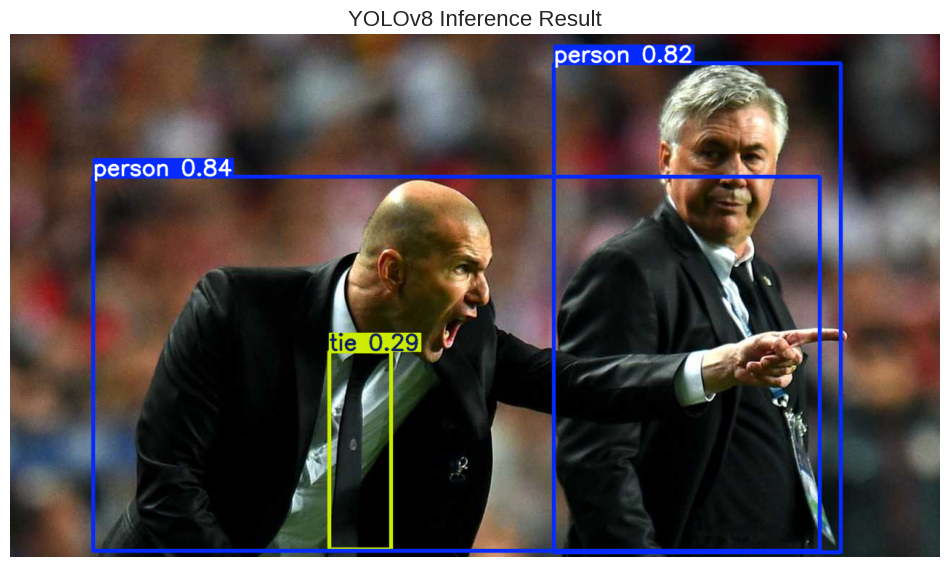

In [3]:
# Load the pre-trained YOLOv8n model
model = YOLO('yolov8n.pt')

# Download a sample image
!wget -O zidane.jpg https://ultralytics.com/images/zidane.jpg -q

# Run inference
# conf=0.25 is the standard confidence threshold
results = model.predict(source='zidane.jpg', conf=0.25, save=False)

# Visualize
plt.figure(figsize=(12, 8))

# Plot the result (results[0].plot() returns a BGR numpy array)
res_plotted = results[0].plot()

# Convert BGR to RGB for matplotlib
plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('YOLOv8 Inference Result', fontsize=16)
plt.show()

## 5. Real-Time Video Processing Simulation

We now apply the model to a video stream. This simulates a real-world scenario, such as traffic monitoring. We will download a high-quality sample video and process it frame-by-frame.

In [4]:
# Download a sample traffic video
video_url = "https://github.com/intel-iot-devkit/sample-videos/raw/master/car-detection.mp4"
!wget -O input_traffic.mp4 "{video_url}" -q

# Run inference on the video
# project='runs/detect' and name='video_exp' ensures deterministic output path
model.predict(source='input_traffic.mp4', save=True, project='runs/detect', name='video_exp', exist_ok=True)

# Path to the saved video (YOLOv8 saves as avi by default usually, but sometimes mp4 depending on codec)
# We check the output directory
output_video_path = 'runs/detect/video_exp/input_traffic.avi'

if not os.path.exists(output_video_path):
    # Fallback check for mp4 if avi doesn't exist
    output_video_path = 'runs/detect/video_exp/input_traffic.mp4'

print(f"Processing complete. Displaying video from: {output_video_path}")

# Display the video
display_video(output_video_path)


WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/377) /content/input_traffic.mp4: 384x640 (no detections), 33.5ms
video 1/1 (frame 2/377) /content/input_traffic.mp4: 384x640 (no detections), 33.7ms
video 1/1 (frame 3/377) /content/input_traffic.mp4: 384x640 (no detections), 12.6ms
video 1/1 (frame 4/377) /content/input_traffic.mp4: 384x640 (no detections), 8.9ms
video 1/1 (frame 5/377) /content/input_traffic.mp4: 384x640 (no detections), 7.1ms
video 1/1 (frame 6/377) /content/input_t

## 6. Performance Analytics

When training or validating YOLOv8 on custom datasets, the model generates several key metrics in the `runs/` directory. Understanding these is crucial for model optimization.

### Confusion Matrix
Shows the detailed classification performance. It highlights:
- **True Positives (TP)**: Correctly detected objects.
- **False Positives (FP)**: Background detected as an object (Ghost detection).
- **False Negatives (FN)**: Missed objects.

### F1-Confidence Curve
The F1 score is the harmonic mean of Precision and Recall: $$F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$$
The F1-Confidence curve helps in selecting the optimal confidence threshold. We typically choose the confidence value that maximizes the F1 score to balance precision and recall.

### mAP (Mean Average Precision)
- **mAP@50**: The average precision calculated at an IoU threshold of 0.50. This is a common metric in Pascal VOC challenges.
- **mAP@50-95**: The average of mAP calculated at varying IoU thresholds (0.50, 0.55, ..., 0.95). This is a more rigorous metric (standard in COCO challenges) requiring high-precision localization.

## 7. Conclusion

In this notebook, we demonstrated the power and efficiency of the **YOLOv8** architecture.

**Key Takeaways:**
1.  **Architecture**: The single-stage design allows for incredibly fast inference suitable for real-time applications.
2.  **Ease of Use**: The `ultralytics` API abstracts complex training and inference loops into simple commands.
3.  **Versatility**: The model generalizes well to different domains (portraits, traffic) without fine-tuning.

**Real-World Applications:**
- **Autonomous Driving**: Real-time pedestrian and vehicle detection (as seen in Section 5).
- **Retail Analytics**: Heatmaps of customer movement and automated checkout systems.
- **Security & Surveillance**: Anomaly detection and perimeter monitoring.

Future work would involve training this model on a custom dataset to detect specific classes of interest, utilizing the same pipeline established here.